# Document Similarity for Retrieval

Some topics to cover 

- Document retrieval in the real world: Recommending similar documents/products    
- Bag of words features
- Descriving text with tf-idf  **<font color='red'>(Exercise Solved)</font>**
- Finding the nearest neighbor: naive approach.
- KDtrees: fast (exact or approximate) search of similar items.
   

In [1]:
import matplotlib
from matplotlib import pyplot as plt
import nltk
import re
import sklearn
import scipy as sp
import numpy as np
plt.style.use('ggplot')
%matplotlib inline

## 1.2) Features for documents


We will denote by

- $W= \{w_1, \dots, w_D\}$ the set of words used to make the representations.
- $X$ our corpus of documents.
- $X_w$ the set of documents that contain word $w$. 

### Bag of words vector  (or `tf` vector)


- The bag of words representation for a document $x$ given a vocabulary $W$, or the term frequency vector **$\text{tf}(X;W)$** is defined as 

$$
\text{tf}(x;W) = \left( \#\{w_1| w_1 \in x\}, \dots, \#\{w_D| w_D \in x\})\right)
$$



### Term frequency Inverse Document frequency ( `tf * idf`)

The objective of tf-idf representation is to emphasize the most relevant words of the documents. We want to emphasize:

- Words that appear **frequently in the document**: term frequency 
- Words that appear **rarely in the corpus**: inverse document frequency

#### Definition of the feature vectors


- The **$\text{tf}(X;W)$** vector for a document $x$ is defined as 

$$
\text{tf}(x;W) = \left( \#\{w_1| w_1 \in x\}, \dots, \#\{w_D| w_D \in x\})\right)
$$

- The **$\text{idf}(W; X)$** vector is defined as 

**$$\text{idf}(W; X) = \left( \text{idf}(w_1; X), \dots, \text{idf}(w_D; X)\right)$$** 
   
$\,\,\,\,\,\,\,$ A component of the feature for word $w \in W$ in the corpus $X$ is defined as 

$$
\text{idf}(w, X) = log\left(\frac{|X|}{1+|X_{w}|}\right)
$$

$\,\,\,\,\,\,\,$Which simply means the full vector is 
$$
\text{idf}(w, X) = \left( log\left(\frac{|X|}{1+|X_{w_1}|}\right), \dots, log\left(\frac{|X|}{1+|X_{w_D}|}\right) \right)
$$

- The tfidf vector for a document $x$ will be: $tf(x; X) * idf(X)$

#### Observations

- If a word appears in a few documents the idf vector will increase its weight.

- If a word appears in a lots of documents documents the idf vector will decrease its weight.

#### `sklearn.feature_extraction.text.TfidfVectorizer`

- Notice that the implementation in sklearn already prevents zero divisions by default. This happens if `smooth_idf=True`.

- By default the tfidf will only use words since `ngram_range=(1, 1)`. But this can be changed to allow n-grams in the feature vector components.

#### Example

Let us assume we have a corpus with one milion documents

- Consider a word appearping in 100 documents:

$$\log\left(\frac{1000.000}{1 + 100} \right) = 9.200$$

- Consider a word appearing in 100.000 documents

$$\log\left(\frac{1000.000}{1 + 100.000} \right) = 2.197$$



In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

### Make your own TfidfVectorizer


#### Generate tf vector
- check results are the same as sklearn

In [3]:
def build_vocabulary(corpus, splitter):
    vocabulary = set()
    X_w = dict()
    
    for document in corpus:
        words      = set(splitter.findall(document.lower()))
        vocabulary = vocabulary.union(words)
        for w in words:
            X_w[w] = X_w.get(w, 0) + 1
            
    return vocabulary, X_w

def term_frequency(document, word_to_ind, splitter, 
                   normalize=True, word_inds=False):
    
    words = splitter.findall(document.lower())
    n_features = len(word_to_ind)
    tf = sp.sparse.lil_matrix( (1, n_features), dtype=float)
    
    word_indices = []
    for w in words:
        word_indices.append(word_to_ind[w])
        tf[0, word_to_ind[w]] += 1

    if word_inds:
        if normalize:
            return tf.multiply(1/sp.sparse.linalg.norm(tf))
        else:
            return tf
    else:
        if normalize:
            return tf.multiply(1/sp.sparse.linalg.norm(tf))
        else:
            return tf

In [4]:
splitter = re.compile('(?u)\\b\\w\\w+\\b')
%time vocabulary, X_w = build_vocabulary(newsgroups_train.data, splitter)

word_to_ind = {v:i for i,v in enumerate(vocabulary)}
ind_to_word = {v:k for k,v in word_to_ind.items()}

CPU times: user 1min 1s, sys: 10.2 s, total: 1min 11s
Wall time: 1min 13s


In [5]:
%time tf = term_frequency(newsgroups_train.data[0],\
                          word_to_ind, splitter, word_inds=False)

CPU times: user 5.28 ms, sys: 1.87 ms, total: 7.15 ms
Wall time: 6.94 ms


#### Generate tf from sklearn and compare

In [6]:
tfidf_sk = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=False,
                                                           smooth_idf=False, 
                                                           sublinear_tf=False)

%time tfidf_sk.fit(newsgroups_train.data)

inverse_vocabulary_ = {v: k for k, v in tfidf_sk.vocabulary_.items()}

CPU times: user 4.86 s, sys: 121 ms, total: 4.99 s
Wall time: 5.07 s


In [7]:
%time x_sk = tfidf_sk.transform([newsgroups_train.data[0]])

CPU times: user 2.5 ms, sys: 1.67 ms, total: 4.17 ms
Wall time: 3.25 ms


/Users/david/anaconda/envs/py3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


#### Comparisson

In [8]:
np.isclose(tf.sum(), x_sk.sum())

True

In [9]:
words_x_own = [ind_to_word[k] for k in tf.nonzero()[1]]
words_x_sk = [inverse_vocabulary_[k] for k in x_sk.nonzero()[1]]

In [10]:
set(words_x_own) == set(words_x_sk)

True

### Generate tfidf and compare with sklearn 

In [11]:
def compute_idf(X_w, word_to_ind, n_documents):

    n_features = len(word_to_ind)
    #idf = sp.sparse.csr_matrix( (1, n_features), dtype=float)
    idf = np.zeros([1, n_features])
    
    for w in X_w:
        idf[0, word_to_ind[w]] = np.log((1+n_documents)/(1 + X_w[w]))+1 
        
    #idf = idf + 1    
    return sp.sparse.csr_matrix(idf)

In [12]:
# lil_matrix is more efficient.
tf = term_frequency(newsgroups_train.data[0], word_to_ind,\
                    splitter, normalize=False,word_inds=False)

idf = compute_idf(X_w,word_to_ind, len(newsgroups_train.data))

In [13]:
idf.max(), idf.min()

(9.640737377507692, 1.0)

In [14]:
n_documents = len(X_w)

In [15]:
tfidf = tf.multiply(idf)
tfidf = tfidf/sp.sparse.linalg.norm(tfidf)
sp.sparse.linalg.norm(tfidf)

1.0

In [16]:
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer()
tfidf_vectorizer.fit(newsgroups_train.data);

In [17]:
tfidf_sklearn = tfidf_vectorizer.transform(newsgroups_train.data[0:1])

/Users/david/anaconda/envs/py3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [18]:
tfidf.data.dtype, tfidf_sklearn.data.dtype

(dtype('float64'), dtype('float64'))

In [19]:
print(tfidf.sum(), tfidf_sklearn.sum())
print(np.isclose(tfidf_sklearn.sum(),tfidf.sum()))

7.697815233022508 7.697815233022508
True


# Finding the most similar element toy example


In [20]:
def closest_point(all_points, query_point, dist):
    closest_point_    = None
    closest_distance_ = np.inf
    
    for current_point in all_points:
        current_distance = dist(query_point, current_point)
        
        if  current_distance < closest_distance_:
            closest_distance_ = current_distance
            closest_point_    = current_point
            
    return closest_point_, closest_distance_

def dist(x,y):
    return np.sqrt(np.linalg.norm((x-y)**2))

Query: [1 3]
Closest to query: [0 3]


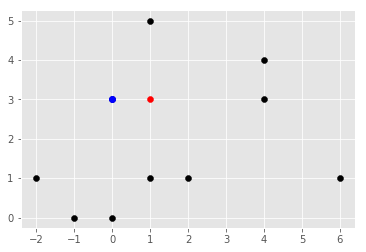

In [21]:

X = np.array([[1,1],[0,3],[4,3],[0,0],[1,5],[6,1],[-2,1],[4,4],[2,1],[-1,0]])
x_components = [x[0] for x in X]
y_components = [x[1] for x in X]
query = np.array([1,3])

closest_to_query, _ = closest_point(X, query, dist)
print("Query: {}\nClosest to query: {}".format(query,closest_to_query))
plt.scatter(x_components, y_components, color="black")
plt.scatter(query[0], query[1], color="red")
plt.scatter(closest_to_query[0], closest_to_query[1], color="blue", linewidths=1, marker="o")

# Finding the most similar element real data

## Closest point in numpy

In [22]:
import sklearn
from sklearn import neighbors

n_features = 40
X = np.random.rand(1000000,n_features).astype(np.float32)
x = np.random.rand(1,n_features).astype(np.float32)

In [23]:
%time distances =  np.mean((X-x)**2,1)
#One second is too much
%time closest = np.argmin(np.mean((X-x)**2,1))
print("\nclosest row from x is {}".format(closest))

CPU times: user 210 ms, sys: 96.7 ms, total: 307 ms
Wall time: 255 ms
CPU times: user 349 ms, sys: 84.6 ms, total: 433 ms
Wall time: 226 ms

closest row from x is 82844


In [24]:
x = X[100,:] + np.random.rand()

## Custom function for closest point

In [25]:
n_features = 40
X = np.random.rand(1000000,n_features).astype(np.float32)
x = np.random.rand(1,n_features).astype(np.float32)

In [26]:
%%time
closest_point_, closest_distance_ = closest_point(X, x, dist)

CPU times: user 14 s, sys: 155 ms, total: 14.2 s
Wall time: 14.3 s


In [27]:
closest_point_

array([0.28066936, 0.46672922, 0.44261822, 0.95386153, 0.36550063,
       0.9916441 , 0.5349925 , 0.76487243, 0.43862563, 0.6367773 ,
       0.51006705, 0.9160756 , 0.16399077, 0.42110866, 0.37581167,
       0.34426594, 0.31198877, 0.5920748 , 0.6790636 , 0.89395803,
       0.4599827 , 0.54770416, 0.8615159 , 0.14637236, 0.12648559,
       0.5757881 , 0.48586133, 0.74784684, 0.2667317 , 0.99904555,
       0.849827  , 0.26170462, 0.06040365, 0.84972125, 0.6484007 ,
       0.35786378, 0.99717844, 0.32505742, 0.7922988 , 0.3157588 ],
      dtype=float32)

In [49]:
closest_distance_

0.62816256

## Build kd trees

In [29]:
%%time
tree = sklearn.neighbors.KDTree(X, leaf_size=100000)

CPU times: user 2.79 s, sys: 162 ms, total: 2.95 s
Wall time: 3.01 s


In [30]:
%%time 
distance_to_closest, closest_kdtree = tree.query(x, k=1)

CPU times: user 182 ms, sys: 1.63 ms, total: 184 ms
Wall time: 185 ms


In [31]:
print("\nclosest row from x is {}".format(closest_kdtree[0][0]))


closest row from x is 996307


In [32]:
closest_kdtree

array([[996307]])

Notice that queries can have k to get the cloest k elements

In [33]:
%time distances_to_closest, close_kdtree = tree.query(x,k=10)

CPU times: user 170 ms, sys: 1.14 ms, total: 171 ms
Wall time: 170 ms


In [34]:
close_kdtree

array([[996307, 369132, 406663, 670786, 401563, 222748, 339689,  66945,
        533785,  30510]])

##  Fast search

Doing NN search can be expensive. Given a query point $\bf{x}$ we need to scan through each point $\bf{x}^m$ in the dataset and compute the distance between $\bf{x}$ and  $\bf{x}^m$. That is:

- $O(N)$ distance computations per 1-NN query 
- $O(N\log(k))$ per k-NN query

If N is huge this can be a problem.

### KD Trees

KD-trees are an efficient structure for efficiently representing our data. KD-trees provide an organization of our documents in terms of a certain partitioning of our space. The organization is based on recursively partitioning points into axis, defining "boxes".

The KD-tree structure is based on making aligned cuts and maintaining lists of points that fall into each one of these different bins. This structure allows us  efficiently prune our search space so that we do not have to visit every single data point, for every query, necessarily. Sometimes we will have to do it but hopefully, in many cases, we will not have to do it.


#### Using KD-trees

Let us see how KD-trees can aid in efficiently making NN search. Let us assume we are given a KD_tree and let us see how to ue it. Later on we will see how to build the tree.

Given a query point $\bf{x}$:

- Traverse the tree until the query point is reached. That is, check all the conditions of the KD-tree for the query point until a leave is reached.
    - Once the query point is found save the "box" where it is found.
    
    
- Compute the distance between each neighbor in the box and the query point.


- Record the smallest distance to the NN so far.


- Backtrack and try other branch at each node visited.
    - Use the distance bound and bounding box of each node to prune parts of the three that cannot include the nearest neighbor.
         
         That is, **if the smallest distance is less than the distance from the query point to the bounding box there is no need to compute the distance between any point in the bounding box to the query point**.



In [35]:
import sklearn
from sklearn import neighbors

In [37]:
X = np.random.rand(1000000,10).astype(np.float32)
x = np.random.rand(1,10).astype(np.float32)

In [38]:
%time distances =  np.mean((X-x)**2,1)

CPU times: user 119 ms, sys: 25.4 ms, total: 145 ms
Wall time: 96 ms


In [39]:
# One second is too much
%time closest_index = np.argmin(np.mean((X-x)**2,1))
print("\nclosest row from x is {}".format(closest))

CPU times: user 146 ms, sys: 11.9 ms, total: 158 ms
Wall time: 80.7 ms

closest row from x is 82844


#### Make more efficient closest implementation

- Why is this more efficient than the previous cell implementation?

In [40]:
def closest_point(all_points, query_point, dist):
    closest_point_    = None
    closest_distance_ = np.inf
    
    for current_point in all_points:
        current_distance = dist(query_point, current_point)
        
        if  current_distance < closest_distance_:
            closest_distance_ = current_distance
            closest_point_    = current_point
            
    return closest_point_, closest_distance_

In [41]:
def dist(x,y):
    return np.sqrt(np.linalg.norm((x-y)**2))

In [42]:
#One second is too much
%time closest = closest_point(X, x, dist)
print("\nclosest row from x is {}".format(closest))

CPU times: user 13.4 s, sys: 227 ms, total: 13.6 s
Wall time: 13.8 s

closest row from x is (array([0.6088857 , 0.4209416 , 0.7173085 , 0.9602473 , 0.90554196,
       0.9596096 , 0.9581918 , 0.6814053 , 0.6317129 , 0.8805297 ],
      dtype=float32), 0.15431845)


In [43]:
X[closest_index, :]

array([0.6088857 , 0.4209416 , 0.7173085 , 0.9602473 , 0.90554196,
       0.9596096 , 0.9581918 , 0.6814053 , 0.6317129 , 0.8805297 ],
      dtype=float32)

### Build kdtree and use it for queries

In [44]:
%time tree = sklearn.neighbors.KDTree(X, leaf_size= 100000)

CPU times: user 922 ms, sys: 40.5 ms, total: 962 ms
Wall time: 963 ms


In [45]:
%time distance_to_closest, closest_kdtree = tree.query(x,k=1)

CPU times: user 21.2 ms, sys: 1.67 ms, total: 22.9 ms
Wall time: 21.8 ms


In [46]:
print("\nclosest row from x is {}".format(closest_kdtree[0][0]))
#distance_to_closest, closest_kdtree


closest row from x is 381348


Notice that queries can have k to get the cloest k elements

In [47]:
%time distances_to_closest, close_kdtree = tree.query(x,k=10)

CPU times: user 51.1 ms, sys: 1.62 ms, total: 52.7 ms
Wall time: 53.5 ms


In [48]:
close_kdtree

array([[381348, 463316, 409224, 331076, 971061, 820789, 115824, 714320,
        755725, 811501]])


#### Complexity of NN search with KD-trees

Complexity for a nearly balanced, binary tree

- Construction complexity
  - Size: 2N -1 nodes (if 1 datapoint at each leaf) O(N)
  - Depth: O(log(N)) 
  - Median heuristic for split value + send points left,right: O(N) at every level of the tree
  - Construction time: O(N log(N))
- 1-NN query
  - traverse down tree to starting point: O(log(N))
  - Maximum backtrack and traverse: O(N) (N nodes in the worst case)
  - Complexity range: O(log(N)) to O(N)

Under some assumptions on the distribution of points we get O(log(N)) distance computations we need to do to compute a NN. Nevertheless the number of copmutations increases exponentially in d (the number of split dimensions the data has).




#### Timing closest to query


#### How to build a KD-tree

Start with a dataset with 2 features.

- Pick a split dimension (feature)
- Pick split value 
- Split the data for that split dimension and split value
- Recurse on each of the groups

The construction of the KD-tree will be based on storing, at each node in the tree, the 

- split dimension chosen
- split value 
- bounding box that is as small as possible while containing points





#### Choosing dimensions and splitting value

People use heuristics to make splitting decisions.

- Which dimension to do the split along ?
  - Widest dimension
  - Alternating dimensions
- Which value to split at?
  - Median value of the observations contained in the current box.
  - Centerpoint value of the current box (ignoring the data in the box).
- When to stop?
  - Fewer than a given number m of data points left.
  - A minimum width of the box is achieved.

The heuristics can have big impact on the final data structure. See the following plot.

![Alt Image Text](./images/heuristic_impact_kdtree.png  "Optional Title")

